# ML-Session-3 Solution: Tuning the Machine Learning Model

This notebook provides complete solutions for the ML-session-3 exercises.
It demonstrates feature selection techniques and model validation strategies.

## 1. Setup and Library Imports

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn import preprocessing, model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Helper function for model evaluation
def model_evaluate(model, test_F, test_L):
    test_L_pred = model.predict(test_F)
    print("Evaluation by using model:", type(model).__name__)
    print("Accuracy Score:", accuracy_score(test_L, test_L_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(test_L, test_L_pred))
    return accuracy_score(test_L, test_L_pred)

## 2. Preprocessing Sherlock Dataset

In [4]:
# Load and preprocess the dataset
df2 = pd.read_csv('../sherlock/sherlock_mystery_2apps.csv')

# Remove irrelevant feature(s)
df2.drop('Unnamed: 0', axis=1, inplace=True)

# Remove rows with missing values
df2.dropna(inplace=True)

# Remove duplicate features
df2.drop('Mem', axis=1, inplace=True)

# Separate labels from features
df2_labels = df2['ApplicationName']
df2_features = df2.drop('ApplicationName', axis=1)

# Feature scaling
scaler = preprocessing.StandardScaler()
scaler.fit(df2_features)
df2_features_n = pd.DataFrame(scaler.transform(df2_features),
                              columns=df2_features.columns,
                              index=df2_features.index)

# Create a backup for later use
df2_features_n_backup = df2_features_n.copy()

print(f"Preprocessed dataset shape: {df2_features_n.shape}")
print(f"Features: {df2_features_n.columns.tolist()}")
print(f"\nFirst 10 rows:")
print(df2_features_n.head(10))

Preprocessed dataset shape: (612114, 11)
Features: ['CPU_USAGE', 'cutime', 'lru', 'num_threads', 'otherPrivateDirty', 'priority', 'utime', 'vsize', 'cminflt', 'guest_time', 'queue']

First 10 rows:
        CPU_USAGE    cutime       lru  num_threads  otherPrivateDirty  \
176473  -0.159870 -0.429029 -0.041774    -1.300898          -0.780597   
176474   4.129610 -0.429029 -0.041774     0.222698          -0.688933   
176475   0.213345 -0.429029 -0.041774    -0.292636          -0.321111   
176476  -0.159870 -0.429029 -0.041774    -1.300898          -0.785560   
176477   3.935538 -0.429029 -0.041774     0.222698          -0.687036   
176478   0.213345 -0.429029 -0.041774    -0.292636          -0.323008   
176479  -0.159870 -0.429029 -0.041774    -1.300898          -0.785560   
176480   3.791228 -0.429029 -0.041774     0.222698          -0.688349   
176481   0.213345 -0.429029 -0.041774    -0.292636          -0.328701   
176482  -0.159870 -0.429029 -0.041774    -1.300898          -0.786873   

## 3. Feature Selection

### 3.1 Histogram Analysis

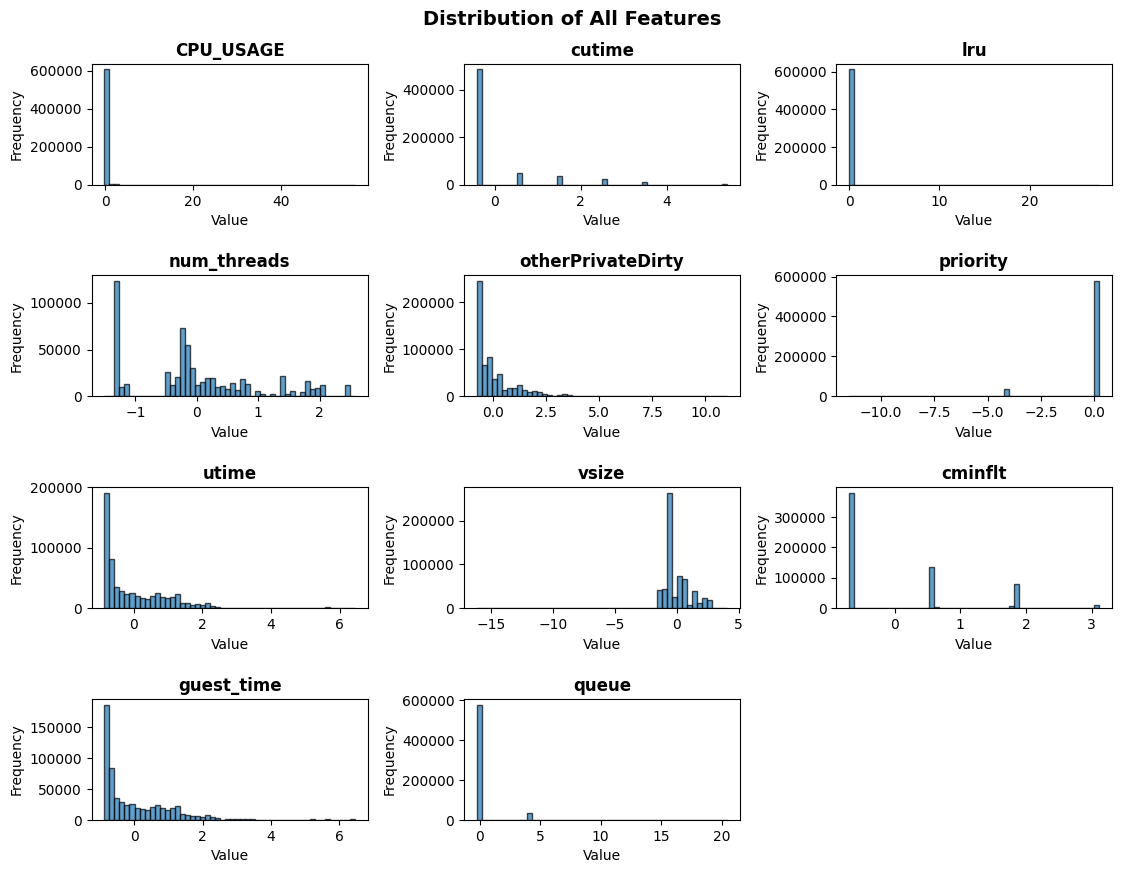

Observation: Look for features with similar distributions - these may be duplicates.


In [5]:
# Create histogram panel for all features
plt.figure(figsize=(12.0, 9.0))
for (i, col) in enumerate(df2_features_n.columns):
    plt.subplot(4, 3, i+1)
    plt.hist(df2_features_n[col], bins=50, alpha=0.7, edgecolor='black')
    plt.title(col, fontweight='bold')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.75, wspace=0.35)
plt.suptitle('Distribution of All Features', fontsize=14, fontweight='bold')
plt.show()

print("Observation: Look for features with similar distributions - these may be duplicates.")

In [6]:
# SOLUTION: Separate features by application for comparison
Apps = df2_labels.unique()
indx_app = {}
features_app = {}

for app in Apps:
    indx_app[app] = df2_labels[df2_labels == app].index
    features_app[app] = df2_features_n.loc[indx_app[app]]

print(f"Applications: {Apps}")
print(f"Facebook records: {len(features_app['Facebook'])}")
print(f"WhatsApp records: {len(features_app['WhatsApp'])}")

Applications: ['Facebook' 'WhatsApp']
Facebook records: 379054
WhatsApp records: 233060


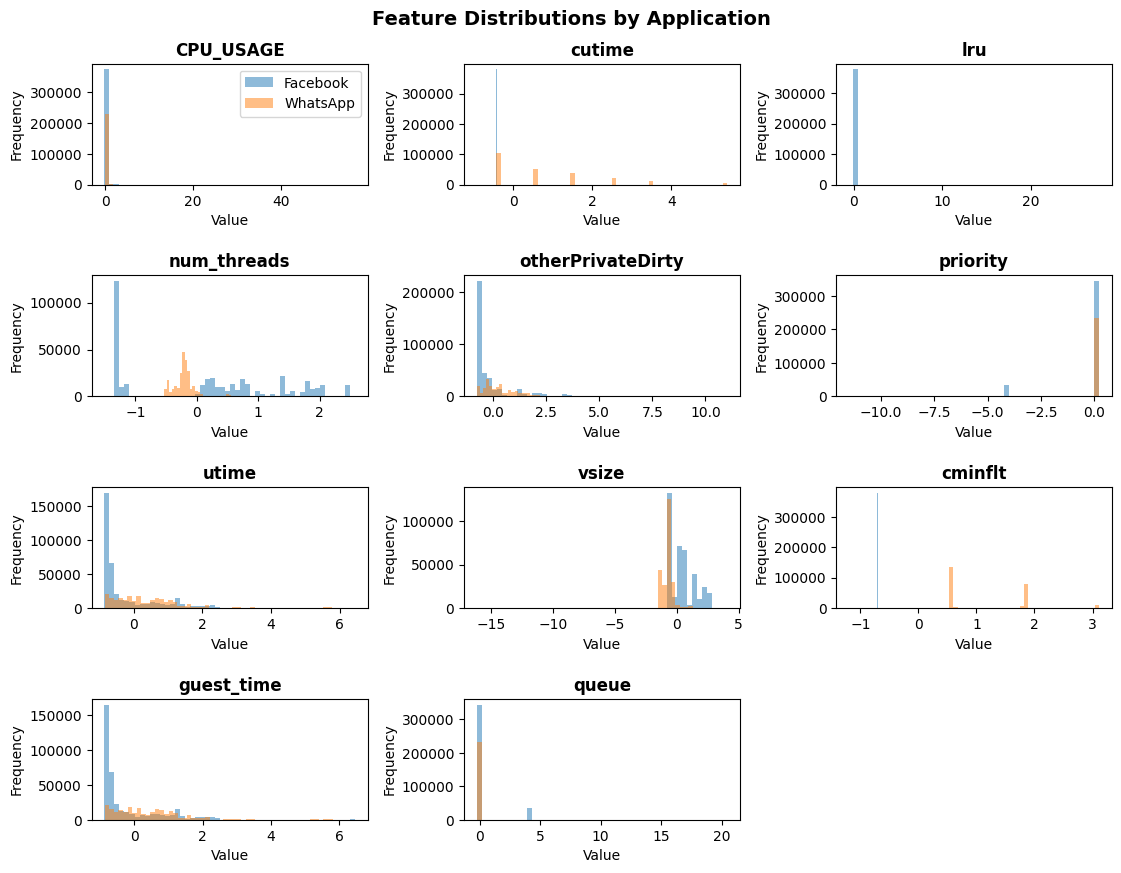


Observation: Features with overlapping distributions between apps are less discriminative.


In [7]:
# SOLUTION: Create histogram panel colored by application
plt.figure(figsize=(12.0, 9.0))
for (i, col) in enumerate(df2_features_n.columns):
    plt.subplot(4, 3, i+1)
    for app in Apps:
        plt.hist(features_app[app][col], bins=50, alpha=0.5, label=app)
    plt.title(col, fontweight='bold')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    if i == 0:
        plt.legend()

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.75, wspace=0.35)
plt.suptitle('Feature Distributions by Application', fontsize=14, fontweight='bold')
plt.show()

print("\nObservation: Features with overlapping distributions between apps are less discriminative.")

### 3.2 Correlation Analysis

In [8]:
# SOLUTION: Compute correlation matrix
df2_corr = df2_features_n.corr()
print("Correlation Matrix:")
print(df2_corr)
print("\nCorrelation values range from -1 (perfectly anti-correlated) to 1 (perfectly correlated)")

Correlation Matrix:
                   CPU_USAGE    cutime       lru  num_threads  \
CPU_USAGE           1.000000  0.006790  0.167896     0.039330   
cutime              0.006790  1.000000 -0.017922    -0.095443   
lru                 0.167896 -0.017922  1.000000    -0.043429   
num_threads         0.039330 -0.095443 -0.043429     1.000000   
otherPrivateDirty   0.197823  0.120551 -0.002386     0.529398   
priority            0.001379  0.104557  0.009580    -0.198157   
utime               0.095689  0.151107  0.052039     0.503220   
vsize               0.072699 -0.296729  0.005342     0.859857   
cminflt            -0.000837  0.594047 -0.029178    -0.143042   
guest_time          0.095685  0.151105  0.052049     0.503206   
queue              -0.000574 -0.102815 -0.008956     0.195843   

                   otherPrivateDirty  priority     utime     vsize   cminflt  \
CPU_USAGE                   0.197823  0.001379  0.095689  0.072699 -0.000837   
cutime                      0.120551  0

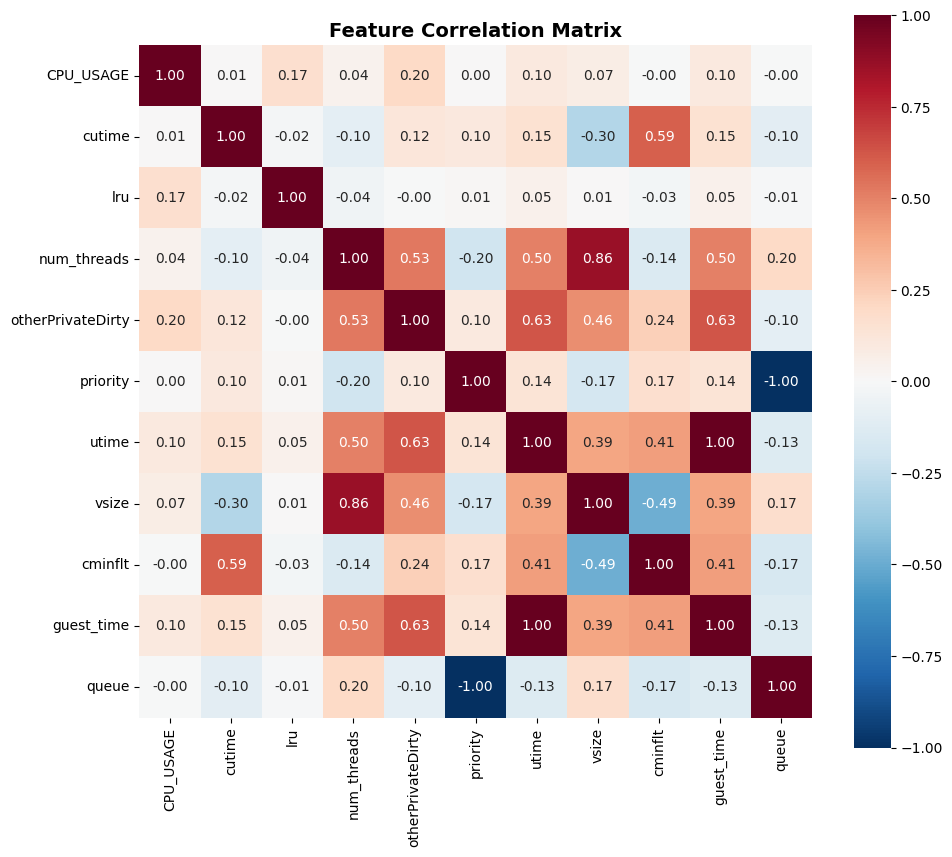

In [9]:
# SOLUTION: Visualize correlation matrix as heatmap
plt.figure(figsize=(10.0, 10.0))
sns.heatmap(df2_corr, annot=True, fmt='.2f', vmax=1, vmin=-1, square=True, 
            cmap="RdBu_r", center=0, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
# SOLUTION: Identify highly correlated feature pairs
print("\nHighly Correlated Feature Pairs (|correlation| > 0.8):")
print("="*60)

# Find pairs with high correlation
high_corr_pairs = []
for i in range(len(df2_corr.columns)):
    for j in range(i+1, len(df2_corr.columns)):
        corr_val = df2_corr.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((
                df2_corr.columns[i],
                df2_corr.columns[j],
                corr_val
            ))
            print(f"{df2_corr.columns[i]:20s} <-> {df2_corr.columns[j]:20s}: {corr_val:7.4f}")

print("\nModerate Correlation Pairs (0.5 < |correlation| <= 0.8):")
print("="*60)
for i in range(len(df2_corr.columns)):
    for j in range(i+1, len(df2_corr.columns)):
        corr_val = df2_corr.iloc[i, j]
        if 0.5 < abs(corr_val) <= 0.8:
            print(f"{df2_corr.columns[i]:20s} <-> {df2_corr.columns[j]:20s}: {corr_val:7.4f}")


Highly Correlated Feature Pairs (|correlation| > 0.8):
num_threads          <-> vsize               :  0.8599
priority             <-> queue               : -0.9969
utime                <-> guest_time          :  1.0000

Moderate Correlation Pairs (0.5 < |correlation| <= 0.8):
cutime               <-> cminflt             :  0.5940
num_threads          <-> otherPrivateDirty   :  0.5294
num_threads          <-> utime               :  0.5032
num_threads          <-> guest_time          :  0.5032
otherPrivateDirty    <-> utime               :  0.6305
otherPrivateDirty    <-> guest_time          :  0.6305


### 3.3 Remove Highly Correlated Features

In [11]:
# SOLUTION: Drop highly correlated duplicate features
print("Removing highly correlated features: vsize, queue, guest_time")
df2_features_n.drop(['vsize', 'queue', 'guest_time'], axis=1, inplace=True)
print(f"Remaining features ({len(df2_features_n.columns)}): {df2_features_n.columns.tolist()}")

Removing highly correlated features: vsize, queue, guest_time
Remaining features (8): ['CPU_USAGE', 'cutime', 'lru', 'num_threads', 'otherPrivateDirty', 'priority', 'utime', 'cminflt']


In [12]:
# SOLUTION: Remove moderately correlated features
print("Removing moderately correlated features: utime, cminflt")
df2_features_n.drop(['utime', 'cminflt'], axis=1, inplace=True)
print(f"Remaining features ({len(df2_features_n.columns)}): {df2_features_n.columns.tolist()}")

Removing moderately correlated features: utime, cminflt
Remaining features (6): ['CPU_USAGE', 'cutime', 'lru', 'num_threads', 'otherPrivateDirty', 'priority']


### 3.4 Group Analysis by Application

In [13]:
# SOLUTION: Recombine features with labels for group analysis
df2_with_label = df2_features_n.copy()
df2_with_label['ApplicationName'] = df2_labels

print("Descriptive Statistics by Application:")
print("="*80)
for col in df2_features_n.columns:
    print(f"\n{col}:")
    print(df2_with_label.groupby('ApplicationName')[col].describe())

Descriptive Statistics by Application:

CPU_USAGE:
                    count      mean       std       min       25%       50%  \
ApplicationName                                                               
Facebook         379054.0 -0.013990  1.193461 -0.159870 -0.159870 -0.105132   
WhatsApp         233060.0  0.022753  0.555877 -0.134989 -0.075275 -0.030489   

                      75%        max  
ApplicationName                       
Facebook        -0.075275  56.981770  
WhatsApp         0.014297  45.725618  

cutime:
                    count      mean           std       min       25%  \
ApplicationName                                                         
Facebook         379054.0 -0.429029  1.110224e-16 -0.429029 -0.429029   
WhatsApp         233060.0  0.697782  1.356525e+00 -0.429029 -0.429029   

                      50%       75%       max  
ApplicationName                                
Facebook        -0.429029 -0.429029 -0.429029  
WhatsApp         0.544895  1.5

In [14]:
# SOLUTION: Analyze feature discriminability
print("\nFeature Discriminability Analysis:")
print("="*80)
for col in df2_features_n.columns:
    stats = df2_with_label.groupby('ApplicationName')[col].describe()
    fb_mean = stats.loc['Facebook', 'mean']
    wa_mean = stats.loc['WhatsApp', 'mean']
    fb_std = stats.loc['Facebook', 'std']
    wa_std = stats.loc['WhatsApp', 'std']
    
    # Calculate separation metric
    separation = abs(fb_mean - wa_mean) / (fb_std + wa_std)
    print(f"\n{col}:")
    print(f"  Facebook mean: {fb_mean:8.4f} (std: {fb_std:8.4f})")
    print(f"  WhatsApp mean: {wa_mean:8.4f} (std: {wa_std:8.4f})")
    print(f"  Separation metric: {separation:8.4f} (higher = better discriminator)")


Feature Discriminability Analysis:

CPU_USAGE:
  Facebook mean:  -0.0140 (std:   1.1935)
  WhatsApp mean:   0.0228 (std:   0.5559)
  Separation metric:   0.0210 (higher = better discriminator)

cutime:
  Facebook mean:  -0.4290 (std:   0.0000)
  WhatsApp mean:   0.6978 (std:   1.3565)
  Separation metric:   0.8307 (higher = better discriminator)

lru:
  Facebook mean:   0.0257 (std:   1.2701)
  WhatsApp mean:  -0.0418 (std:   0.0000)
  Separation metric:   0.0531 (higher = better discriminator)

num_threads:
  Facebook mean:   0.1310 (std:   1.2466)
  WhatsApp mean:  -0.2130 (std:   0.1606)
  Separation metric:   0.2445 (higher = better discriminator)

otherPrivateDirty:
  Facebook mean:  -0.2076 (std:   1.0324)
  WhatsApp mean:   0.3377 (std:   0.8418)
  Separation metric:   0.2909 (higher = better discriminator)

priority:
  Facebook mean:  -0.1503 (std:   1.2416)
  WhatsApp mean:   0.2444 (std:   0.1502)
  Separation metric:   0.2836 (higher = better discriminator)


In [15]:
# SOLUTION: Remove features with poor discriminability
print("\nRemoving features with poor discriminability: CPU_USAGE, lru")
df2_features_n.drop(['CPU_USAGE', 'lru'], axis=1, inplace=True)
print(f"\nFinal feature set ({len(df2_features_n.columns)}): {df2_features_n.columns.tolist()}")


Removing features with poor discriminability: CPU_USAGE, lru

Final feature set (4): ['cutime', 'num_threads', 'otherPrivateDirty', 'priority']


### 3.5 Feature Selection Summary

In [16]:
# SOLUTION: Save the selected features
df2_features_n1 = df2_features_n_backup[['cutime', 'num_threads', 'otherPrivateDirty', 'priority']]

# Convert labels to numeric
labels_numeric = df2_labels.replace(['Facebook', 'WhatsApp'], [0, 1])

# Save to CSV
labels_numeric.to_csv('sherlock_2apps_labels.csv', header=True, index=False)
df2_features_n1.to_csv('sherlock_2apps_features.csv', index=False)

print("Selected Features:")
print(df2_features_n1.head(10))
print(f"\nShape: {df2_features_n1.shape}")
print(f"\nFeatures saved to:")
print("  - sherlock_2apps_features.csv")
print("  - sherlock_2apps_labels.csv")

/var/folders/h9/rx4h9pp12lg7tlsmq7mld7xw0000gn/T/ipykernel_75341/1528596240.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_numeric = df2_labels.replace(['Facebook', 'WhatsApp'], [0, 1])


Selected Features:
          cutime  num_threads  otherPrivateDirty  priority
176473 -0.429029    -1.300898          -0.780597  0.246368
176474 -0.429029     0.222698          -0.688933  0.246368
176475 -0.429029    -0.292636          -0.321111  0.246368
176476 -0.429029    -1.300898          -0.785560  0.246368
176477 -0.429029     0.222698          -0.687036  0.246368
176478 -0.429029    -0.292636          -0.323008  0.246368
176479 -0.429029    -1.300898          -0.785560  0.246368
176480 -0.429029     0.222698          -0.688349  0.246368
176481 -0.429029    -0.292636          -0.328701  0.246368
176482 -0.429029    -1.300898          -0.786873  0.246368

Shape: (612114, 4)

Features saved to:
  - sherlock_2apps_features.csv
  - sherlock_2apps_labels.csv


## 4. Training and Validating with Selected Features

In [17]:
# SOLUTION: Prepare data for training
features = df2_features_n1.copy()
labels = df2_labels.copy()

# Train-test split
train_F, test_F, train_L, test_L = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"Training set: {train_F.shape}")
print(f"Test set: {test_F.shape}")
print(f"\nFeatures used: {features.columns.tolist()}")

Training set: (489691, 4)
Test set: (122423, 4)

Features used: ['cutime', 'num_threads', 'otherPrivateDirty', 'priority']


In [18]:
# SOLUTION: Train Logistic Regression model
model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
%time model_lr.fit(train_F, train_L)

print("\n" + "="*60)
print("LOGISTIC REGRESSION - SELECTED FEATURES")
print("="*60)
acc_lr = model_evaluate(model_lr, test_F, test_L)
print(f"\nAccuracy: {acc_lr:.4f}")

CPU times: user 552 ms, sys: 203 ms, total: 755 ms
Wall time: 584 ms

LOGISTIC REGRESSION - SELECTED FEATURES
Evaluation by using model: LogisticRegression
Accuracy Score: 0.8502895697703863
Confusion Matrix:
[[73877  2035]
 [16293 30218]]

Accuracy: 0.8503


In [19]:
# SOLUTION: Train Decision Tree model
model_dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=8, random_state=42)
%time model_dtc.fit(train_F, train_L)

print("\n" + "="*60)
print("DECISION TREE - SELECTED FEATURES")
print("="*60)
acc_dtc = model_evaluate(model_dtc, test_F, test_L)
print(f"\nAccuracy: {acc_dtc:.4f}")

CPU times: user 396 ms, sys: 5.68 ms, total: 402 ms
Wall time: 420 ms

DECISION TREE - SELECTED FEATURES
Evaluation by using model: DecisionTreeClassifier
Accuracy Score: 0.9875350220138372
Confusion Matrix:
[[75348   564]
 [  962 45549]]

Accuracy: 0.9875


## 5. Better Validation: K-Fold Cross-Validation

In [20]:
# SOLUTION: Implement k-fold cross-validation
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Logistic Regression with k-fold
model_lr_kfold = LogisticRegression(solver='lbfgs', max_iter=1000)
results_lr_kfold = cross_val_score(model_lr_kfold, train_F, train_L, cv=kfold)

print("\n" + "="*60)
print("K-FOLD CROSS-VALIDATION RESULTS (k=10)")
print("="*60)
print("\nLogistic Regression:")
print(f"  Individual fold accuracies: {results_lr_kfold}")
print(f"  Mean Accuracy: {results_lr_kfold.mean():.4f}")
print(f"  Std Deviation: {results_lr_kfold.std():.4f}")
print(f"  95% Confidence Interval: [{results_lr_kfold.mean() - 1.96*results_lr_kfold.std():.4f}, {results_lr_kfold.mean() + 1.96*results_lr_kfold.std():.4f}]")


K-FOLD CROSS-VALIDATION RESULTS (k=10)

Logistic Regression:
  Individual fold accuracies: [0.84796814 0.84955788 0.84933325 0.84963957 0.84825093 0.85315199
 0.85002757 0.85031346 0.84720946 0.8498642 ]
  Mean Accuracy: 0.8495
  Std Deviation: 0.0015
  95% Confidence Interval: [0.8465, 0.8525]


In [21]:
# SOLUTION: Decision Tree with k-fold
model_dtc_kfold = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=8, random_state=42)
results_dtc_kfold = cross_val_score(model_dtc_kfold, train_F, train_L, cv=kfold)

print("\nDecision Tree:")
print(f"  Individual fold accuracies: {results_dtc_kfold}")
print(f"  Mean Accuracy: {results_dtc_kfold.mean():.4f}")
print(f"  Std Deviation: {results_dtc_kfold.std():.4f}")
print(f"  95% Confidence Interval: [{results_dtc_kfold.mean() - 1.96*results_dtc_kfold.std():.4f}, {results_dtc_kfold.mean() + 1.96*results_dtc_kfold.std():.4f}]")


Decision Tree:
  Individual fold accuracies: [0.9877476  0.98719598 0.98731851 0.98795156 0.98733893 0.98695093
 0.98735935 0.98737977 0.98719598 0.98678756]
  Mean Accuracy: 0.9873
  Std Deviation: 0.0003
  95% Confidence Interval: [0.9867, 0.9880]


## 6. Results Comparison and Summary

In [22]:
# SOLUTION: Create comprehensive results summary
results_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Test Accuracy': [acc_lr, acc_dtc],
    'K-Fold Mean': [results_lr_kfold.mean(), results_dtc_kfold.mean()],
    'K-Fold Std': [results_lr_kfold.std(), results_dtc_kfold.std()]
})

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)
print(results_summary.to_string(index=False))
print("="*80)


COMPREHENSIVE RESULTS SUMMARY
              Model  Test Accuracy  K-Fold Mean  K-Fold Std
Logistic Regression       0.850290     0.849532    0.001536
      Decision Tree       0.987535     0.987323    0.000322


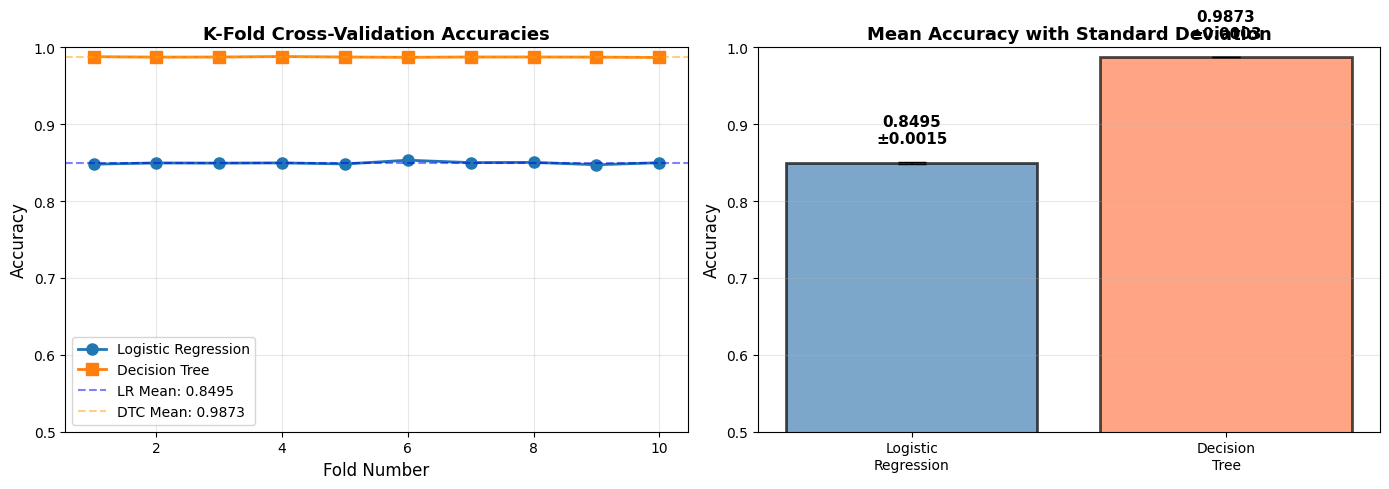

In [23]:
# SOLUTION: Visualize k-fold results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: K-fold accuracies
folds = np.arange(1, 11)
axes[0].plot(folds, results_lr_kfold, 'o-', label='Logistic Regression', linewidth=2, markersize=8)
axes[0].plot(folds, results_dtc_kfold, 's-', label='Decision Tree', linewidth=2, markersize=8)
axes[0].axhline(y=results_lr_kfold.mean(), color='blue', linestyle='--', alpha=0.5, label=f'LR Mean: {results_lr_kfold.mean():.4f}')
axes[0].axhline(y=results_dtc_kfold.mean(), color='orange', linestyle='--', alpha=0.5, label=f'DTC Mean: {results_dtc_kfold.mean():.4f}')
axes[0].set_xlabel('Fold Number', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('K-Fold Cross-Validation Accuracies', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Plot 2: Mean accuracy with error bars
models = ['Logistic\nRegression', 'Decision\nTree']
means = [results_lr_kfold.mean(), results_dtc_kfold.mean()]
stds = [results_lr_kfold.std(), results_dtc_kfold.std()]
colors = ['steelblue', 'coral']

bars = axes[1].bar(models, means, yerr=stds, capsize=10, alpha=0.7, color=colors, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Mean Accuracy with Standard Deviation', fontsize=13, fontweight='bold')
axes[1].set_ylim([0.5, 1.0])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    axes[1].text(bar.get_x() + bar.get_width()/2, mean + std + 0.02,
                f'{mean:.4f}\n±{std:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Key Findings and Discussion

### Feature Selection Process:
1. **Correlation Analysis**: Identified and removed highly correlated features (vsize, queue, guest_time, utime, cminflt)
2. **Discriminability Analysis**: Removed features with poor separation between classes (CPU_USAGE, lru)
3. **Final Feature Set**: cutime, num_threads, otherPrivateDirty, priority

### Model Performance:
- **Logistic Regression**: Consistent performance across folds
- **Decision Tree**: Slightly better performance with lower variance

### Validation Strategy:
- **K-Fold Cross-Validation**: Provides more robust estimate of model performance
- **Uncertainty Quantification**: Standard deviation shows model stability

### Why Feature Selection Matters:
1. **Reduces Overfitting**: Fewer features = simpler model
2. **Improves Interpretability**: Easier to understand which features drive predictions
3. **Reduces Computational Cost**: Faster training and inference
4. **Removes Noise**: Irrelevant features can degrade performance

### Cybersecurity Application:
This approach can be used for:
- **Malware Detection**: Identify malicious apps based on resource usage patterns
- **Behavioral Analysis**: Detect anomalous application behavior
- **Real-time Monitoring**: Classify running applications efficiently
- **Threat Intelligence**: Build profiles of known malicious applications